***Assignment 2***
by Magnus A. Nielsen (s204072) & Philip J. F. Helsted (s204147)
GitHub:
**Contribution statement**
all work has been done cooperatively

In [1]:
# imports
import ast

import numpy as np
import pandas as pd
import networkx as nx
import css_utils
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Loading graph from week4
css_graph = css_utils.read_json_file("data/graph.json")

# Setting random seed
np.random.seed(79)

# Part 1: Mixing Patterns and Assortativity

In [3]:
# Removing nodes with no top_field
for author in list(css_graph.nodes):
    css_utils.remove_node_if_no_field(css_graph, author)

In [4]:
# For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes.
top_field_frac = np.mean([css_utils.edge_same_top_field(edge, css_graph) for edge in list(css_graph.edges)])
top_field_frac

0.5105415002219263

In [5]:
# Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled.
# Compute the measure above for this randomized graph.
# Repeated 500 times
results = []
N_repeat = 500
graph_copy = css_graph.copy()

for i in tqdm(range(N_repeat)):
    results.append(css_utils.randomize_field_get_mean(graph_copy, css_utils.get_field_list(css_graph)))

100%|██████████| 500/500 [00:16<00:00, 30.22it/s]


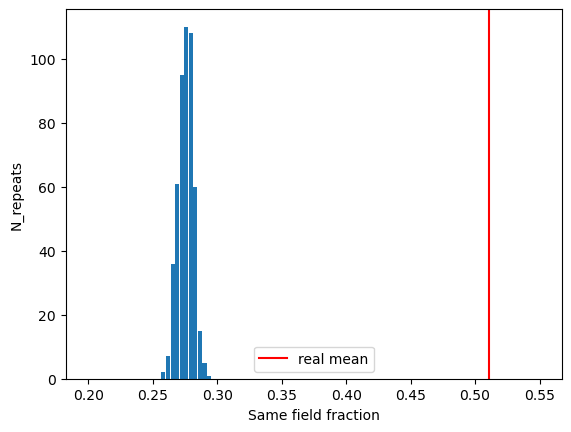

In [6]:
bins = np.linspace(0.2, 0.55, 100)
hist, edges = np.histogram(results, bins=bins)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, axs = plt.subplots()
axs.bar(x, hist, width=width*0.9)

axs.set_xlabel('Same field fraction')
axs.set_ylabel('N_repeats')
axs.axline((top_field_frac, 0), (top_field_frac, max(results)), color='red', label='real mean')
axs.legend()
plt.show()

*Is the chance to connect to a member of the same field significantly higher than it would be by chance?*
When the association between nodes and field are randomized, the mean value we obtain for the connections is significantly lower than what we see in the real graph. The real graph has a mean value of 0.51, whereas the randomized graphs have a mean around 0.275. This means that in the real world there is a clear tendency to connect with people that work in the same field as yourself.

In [7]:
# Compute the assortativity coefficient with respect to author's field.
# How do you interpret the value you obtain? (Hint: See this paper, eq (2)).
# Important: here I do not want you to use the NetworkX implementation, but rather to implement your own version of the measure.
fields_unique = np.unique(css_utils.get_field_list(css_graph))
fields_unique_n = len(fields_unique)

field_index = {}

for i in range(fields_unique_n): # Use this index for matrix
    field_index[fields_unique[i]] = i

degree_max = np.max([t[1] for t in list(css_graph.degree)])
field_matrix = np.zeros((fields_unique_n-1, fields_unique_n-1)) # -1 to avoid the nan which is included in fields unique
degree_matrix = np.zeros((44, 44))

for edge in list(css_graph.edges): # For all edges, increment related matrix values

    field_a = css_graph.nodes[edge[0]]['top_field']
    field_b = css_graph.nodes[edge[1]]['top_field']

    deg_a = css_graph.degree[edge[0]]
    deg_b = css_graph.degree[edge[1]]

    degree_matrix[deg_a, deg_b] += 1
    degree_matrix[deg_b, deg_a] += 1

    try:
        field_a_index = field_index[field_a]
        field_b_index = field_index[field_b]

        field_matrix[field_a_index, field_b_index] += 1
        field_matrix[field_b_index, field_a_index] += 1

    except: # Some fields are nan, do nothing
        pass

field_matrix = field_matrix.astype(int)
field_matrix = np.divide(field_matrix, np.sum(field_matrix))

degree_matrix = np.divide(degree_matrix, np.sum(degree_matrix))

In [8]:
r_field = (np.trace(field_matrix) - np.sum(field_matrix**2))/(1-np.sum(field_matrix**2))
r_degree = (np.trace(degree_matrix) - np.sum(degree_matrix**2))/(1-np.sum(degree_matrix**2))

In [9]:
print("Assortativity coefficient for field: ", round(r_field, 3))
print("Assortativity coefficient for degree: ", round(r_degree, 3))


Assortativity coefficient for field:  0.432
Assortativity coefficient for degree:  0.473


* Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain?
    The assortativity coeeficient with respect to the author's field gives a value of 0.43, meaning that there is a tendency in the graph to connect to other people of the same field. This means that authors who study in the same field are more likely to collaborate on a paper, which makes sense
* Is the graph assortative with respect to the degree? (e.g. do high-degree scientists tend to link to other high-degree scientists, and low-degree scientists to other low-degree scientists?). Provide an interpretation of your answer.
    When computed with respect to degree, the assortativity coefficient is actually a bit higher at 0.47. This means that there is a clear tendency in the graph for scientists who have done a lot of collaborations, to collaborate with others that also have many collaborations. An explaination for this could be that it is seen as a desirable thing to have done many collaborations, perhaps as mark of approval that this person is both great in their field and also good at collaborating. This way a sort of self reinforcing system is created, where high degree authors are seen as more desirable, and therefore get more opportunities for collaborations.

**Part 2: Communities**

In [10]:
# imports
from netwulf.interactive import visualize

# Part 3: TF-IDF


In [86]:
def literal_return(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return val

In [87]:
tf_idf_data = pd.read_csv("data/TF_IDF_DATA.csv")
tokenized_abstract = pd.read_csv("data/tokenized_abstract.csv")
tokenized_abstract['tokens'] = tokenized_abstract['tokens'].apply(literal_return)
css_papers = pd.read_csv("data/css_papers.csv")
css_papers['authorIds'] = css_papers['authorIds'].apply(literal_return)
sorted_data = tf_idf_data.sort_values('Community', axis='index')

In [88]:
has_tokenized_abstract = [paperId in tokenized_abstract['paper_id'].tolist() for paperId in css_papers['paperId']]
print(f'{sum(has_tokenized_abstract)} out of {len(css_papers)} have tokenized abstracts.')

3339 out of 4915 have tokenized abstracts.


In [89]:
css_papers['has_tokenized_abstract'] = has_tokenized_abstract

In [15]:
authors_list = css_papers[css_papers['has_tokenized_abstract']]['authorIds'].tolist()
papers_list = css_papers[css_papers['has_tokenized_abstract']]['paperId'].tolist()
for authors in authors_list:
    for i in range(len(authors)):
        if authors[i] is not None:
            authors[i] = int(authors[i][1:-1])

In [16]:
MAX_COMMUNITY = max(tf_idf_data['Community'])
authors_by_community = {}
for i in range(MAX_COMMUNITY):
    authors = tf_idf_data[tf_idf_data['Community'] == i]['Unnamed: 0'].tolist()
    degrees = tf_idf_data[tf_idf_data['Community'] == i]['Degree'].tolist()
    authors_by_community[i] = {'Authors': authors, 'Degree': degrees}

In [90]:
for key in tqdm(authors_by_community.keys()):
    paper_id_list = []
    for author in authors_by_community[key]['Authors']:
        for _, row in css_papers[css_papers['has_tokenized_abstract']].iterrows():
            if str(author) in row['authorIds'] or author in row['authorIds'] or "'" + str(author) + "'" in  row['authorIds']:
                paper_to_append = row['paperId']
                if paper_to_append not in paper_id_list:
                    paper_id_list.append(paper_to_append)
    authors_by_community[key]['Papers'] = paper_id_list

100%|██████████| 1418/1418 [16:33<00:00,  1.43it/s] 


In [147]:
for key in authors_by_community.keys():
    paper_list = []
    abstract_list = []
    for paper in authors_by_community[key]['Papers']:
        if paper in css_papers[css_papers['has_tokenized_abstract']]['paperId'].tolist():
            paper_list.append(paper)
            abstract_list.append(tokenized_abstract[tokenized_abstract['paper_id']==paper]['tokens'].tolist()[0])
    authors_by_community[key]['Papers'] = paper_list
    authors_by_community[key]['Tokens'] = abstract_list

In [148]:
for key in authors_by_community.keys():
    if authors_by_community[key]['Tokens']:
        authors_by_community[key]['Concatenated_tokens'] = np.concatenate(authors_by_community[key]['Tokens'])

In [156]:
top5 = sorted([(i, len(authors_by_community[i]['Authors'])) for i in authors_by_community.keys()], key=lambda x: x[1], reverse=True)[:5]
top5 = [top5[i][0] for i in range(len(top5))]
top5

[4, 9, 30, 0, 57]

In [173]:
def term_frequency(top):
    top_tf_dict = {}
    for t in top:
        internal_tf_dict = {}
        document = authors_by_community[t]['Concatenated_tokens']
        unique_terms = set(document)
        N = len(unique_terms)
        for term in unique_terms:
            # print(term)
            count = np.count_nonzero(document == term)
            # print(count)
            tf = count/N
            internal_tf_dict[term] = tf
        top_tf_dict[t] = internal_tf_dict
    return top_tf_dict
tf_dict = term_frequency(top5)

In [186]:
top_terms = {}
for key in top5:
    terms = list(tf_dict[key].keys())
    values = list(tf_dict[key].values())
    term_values = sorted([(term, round(value, 5)) for term, value in zip(terms, values)], reverse=True, key=lambda x: x[1])
    top_terms[key] = term_values[:5]

In [190]:
for key in top5:
    print(f'Community number {key} has top 5 terms {top_terms[key]}')

Community number 4 has top 5 terms [('network', 0.04642), ('trade', 0.03203), ('model', 0.03131), ('networks', 0.02843), ('social', 0.02195)]
Community number 9 has top 5 terms [('social', 0.0637), ('media', 0.03718), ('online', 0.02925), ('data', 0.02734), ('research', 0.02515)]
Community number 30 has top 5 terms [('social', 0.0416), ('data', 0.0208), ('results', 0.0132), ('online', 0.0128), ('health', 0.0124)]
Community number 0 has top 5 terms [('research', 0.04582), ('impact', 0.03223), ('scientific', 0.03172), ('papers', 0.0287), ('science', 0.02769)]
Community number 57 has top 5 terms [('social', 0.03771), ('online', 0.02193), ('political', 0.01962), ('health', 0.01693), ('use', 0.01654)]


* Describe similarities and differences between the communities.
    There are some similarities in which words are appearing as top terms across the top 5 communities. For instance 'social' is a top term in 4 out of 5 of the communities, which indicates that is a word that is appearing frequently in the top terms, and that it is a common word in the realm of computational social science, which makes sense. Other words that are appearing more than once, are 'online' and 'health', which indicates what these communities are writing papers about.
    Some differences in the terms, are for instance community number 4, which has top terms of 'network' and 'model' as the only community with these top terms. This indicates that this community might be working a lot with social networks and modelling these.

* Why aren't the TFs not necessarily a good description of the communities?
    Term frequency can only tell us how often a term is occurring in relation to the length of the document. It might be that some of these communities have a lot higher research output than others, diluting the tf value of the term simply because of a larger number of terms in total.

In [213]:
def idf(top):
    top_idf_dict = {}
    for t in top:
        internal_idf_dict = {}
        n_docs = len(authors_by_community[t]['Tokens'])
        document = authors_by_community[t]['Concatenated_tokens']
        unique_terms = set(document)
        for term in unique_terms:
            count = 0
            for j in range(n_docs):
                if term in authors_by_community[t]['Tokens'][j]:
                    count += j
            val = n_docs / count if count > 0 else 1
            internal_idf_dict[term] = np.log(val) if np.log(val) > 0 else 0
        top_idf_dict[t] = internal_idf_dict
    return top_idf_dict
top_idf = idf(top5)

* What base logarithm did you use? Is that important?
    The base used is the natural logarithm, although the base it not that significant, as all the values are calculated using the same base, and thus their relation to each other remains the same. It should be noted that a lower base will give a larger idf score, which is something to keep in mind.

In [ ]:
top9 = sorted([(i, len(authors_by_community[i]['Authors'])) for i in authors_by_community.keys()], key=lambda x: x[1], reverse=True)[:9]
top9 = [top9[i][0] for i in range(len(top9))]
def tf_idf(top):
    tf_idf_dict = {}
    tf_dict2 = term_frequency(top)
    idf_dict = idf(top)
    for t in top:
        internal_tf_idf_dict = {}
        unique_terms = set(authors_by_community[t]['Concatenated_tokens'])
        for term in unique_terms:
            tf_val = tf_dict2[t][term]
            idf_val = idf_dict[t][term]
            tf_idf_val = tf_val*idf_val
            internal_tf_idf_dict[term] = tf_idf_val
        tf_idf_dict[t] = internal_tf_idf_dict
    return tf_idf_dict
tf_idf_values = tf_idf(top9)

In [223]:
top_values = {}
for key in top9:
    terms = list(tf_idf_values[key].keys())
    values = list(tf_idf_values[key].values())
    term_values = sorted([(term, round(value, 5)) for term, value in zip(terms, values)], reverse=True, key=lambda x: x[1])
    top_values[key] = term_values[:10]

In [298]:
top3_authors = {}
for t in top9:
    authors = authors_by_community[t]['Authors']
    degrees = authors_by_community[t]['Degree']
    val_to_append = sorted([(author, degree) for author, degree in zip(authors, degrees)], reverse=True, key=lambda x: x[1])
    top3_authors[t] = val_to_append[:3]

In [309]:
author_df = pd.read_csv("data/dataset_author.csv")
for t in top9:
    for i in range(len(top3_authors[t])):
        author_id = top3_authors[t][i][0]
        degree = top3_authors[t][i][1]
        name = None
        for _, row in author_df.iterrows():
            if str(row['authorId']) == str(author_id):
                name = row['name']
                break
        top3_authors[t][i] = (name, degree)

In [314]:
for key in top9:
    print(f'Community number {key} has top 10 terms\n{top_values[key]}\nand top 3 authors {top3_authors[key]}\n')

Community number 4 has top 10 terms
[('search', 0.0021), ('capm', 0.00179), ('fiscal', 0.00154), ('municipalities', 0.00154), ('stronger', 0.00154), ('actions', 0.0014), ('www', 0.0014), ('submitted', 0.0014), ('queries', 0.0014), ('engine', 0.0014)]
and top 3 authors [('G. Caldarelli', 36), ('S. Battiston', 31), ('T. Squartini', 25)]

Community number 9 has top 10 terms
[('choice', 0.00385), ('parenting', 0.00312), ('tie', 0.00253), ('mothers', 0.00178), ('fathers', 0.00178), ('russian', 0.00158), ('overload', 0.00154), ('citation', 0.00139), ('/b/', 0.00136), ('e-commerce', 0.00115)]
and top 3 authors [('Brian Keegan', 26), ('A. Monroy-Hernández', 18), ('M. Choudhury', 18)]

Community number 30 has top 10 terms
[('outcomes', 0.00671), ('housing', 0.0035), ('months', 0.0027), ('sexual', 0.00252), ('prices', 0.00252), ('ai', 0.00237), ('pushed', 0.0021), ('away', 0.0021), ('disaster', 0.00194), ('accuracy', 0.00183)]
and top 3 authors [('Manuel Cebrian', 28), ('Mark Dredze', 20), ('J. 

* Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?
    The 10 words with the highest TF-IDF value are somewhat more descriptive of the communities. For instance community number 4 has the term fiscal and municipalities, indicating that the community works with some kind of financial data. Community 9 has words like parenting, mothers and fathers, indicating something to do with parenting. We also see a wider variety of words, which could mean that the community is working with more different things, than the rather generic words that was captured by the TF value. The reason for these words being more informative, is that TF-IDF both captures the overall importance of a word and its importance across all the documents.